In [1]:
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from matplotlib import patches
from torchvision import io
import torch
import numpy as np
from CONFIG import config
from datalib import build_data_loader, load_data
from datalib.transforms import ParameterCompose,RandomHorizontalFlip,RandomVerticalFlip
%load_ext autoreload
%autoreload 2

### Data Visualization

* Here, we investigate the transforms on train dataset. We compare the data in a sequence before and after the transformations being applied. 
* The transforms are implemented to equally to all the samples in a sequence, preserving the time consistanct of the video sequence.
* Each new sequence gets fresh random decisions for augmentation. This is done in MoviC.py file line 50 (self.transforms.reset_sequence(sequence_idx=idx), num_epochs=self.num_epochs) resets the flags for horizontal and vertical flips.
* For the sake of having the same transformation on all data in a sequence, we needed to have different seeds per sequence. But at the same time we need a base/stable seed during training the model and initializeing the tensors. To solve this problem, we considered the seed for training as `base_seed` which is increased by idx - the index of the sequence in the dataset - and also a random value in range(epoch). This ensures both consistancy during data augmentatin per sequence, diversity per sequence/epoch, and also during training procecss for tensors (having a defined base-seed).( This is done in _make_sequence_decisions() function line 35 in MoviC.py). Although this approach provides deterministicc results for agumentation `per_sequence`, is it non-deterministic `per run`!

* For each sequence, the choosen augmentation can be aither vertical, horizontal, both, or neither! This is also done in _make_sequence_decisions() function in MoviC.py. We consider independent probabilities for each augmentation:

    - should_hflip = random.random() < 0.3: 30% chance of horizontal flip.
    - should_vflip = random.random() < 0.7: 70% chance of vertical flip.

    Since these are independent, the possible outcomes per sequence are:

    - Neither: (1-0.3) * (1-0.7) = 70% * 30% = 21% probability.

    - Horizontal only: 30% * 30% = 9% probability.

    - Vertical only: 70% * 70% = 49% probability.

    - Both: 30% * 70% = 21% probability.

    

In [2]:

# Apply transforms to ENTIRE sequence using transform pipeline

path = config['data']['dataset_path']
train_dataset = load_data(path, split='train', use_transforms=False)
train_dataset_transformed = load_data(path, split='train', use_transforms=True)


[INFO] - TRAIN Data Loaded: Coordinates: 9737, Masks: 9737, RGB videos:  9737, Flows:  9737
[INFO] - TRAIN Data Loaded: Coordinates: 9737, Masks: 9737, RGB videos:  9737, Flows:  9737


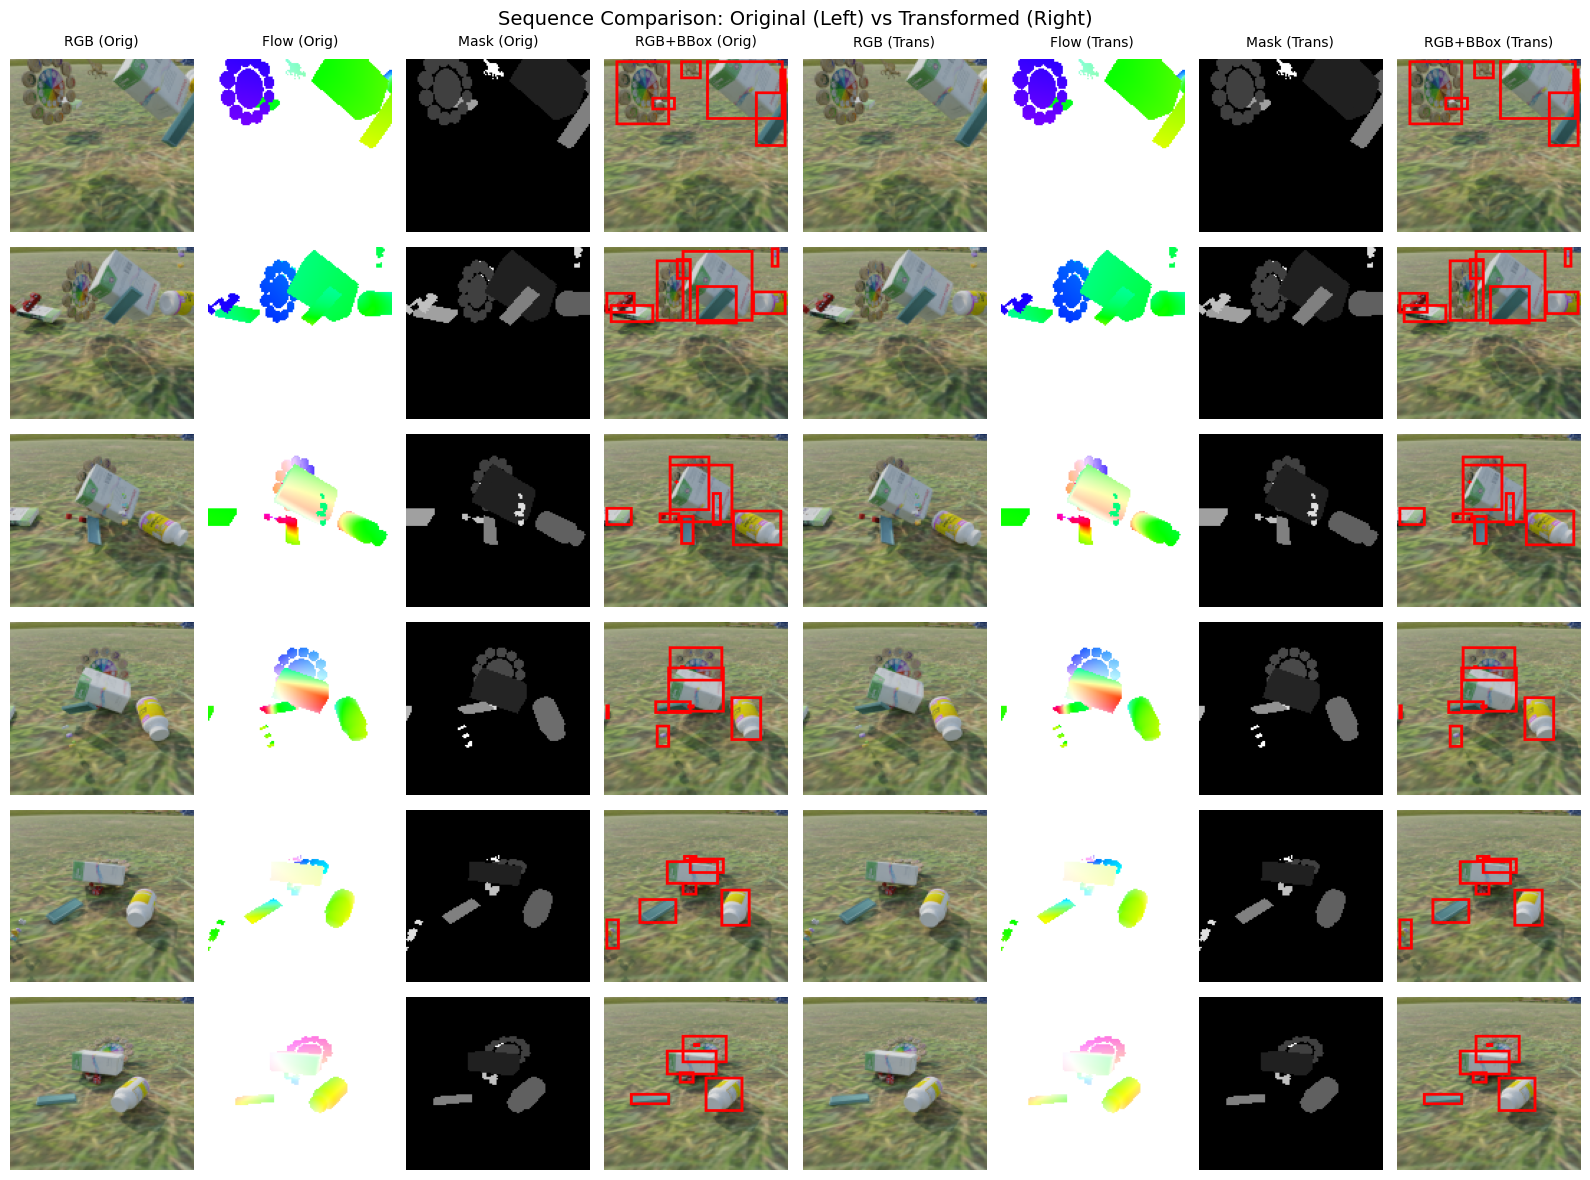

In [3]:
from utils.utils import plot_sequence_comparison


idx = np.random.randint(0, len(train_dataset))

rgbs_orig, masks_orig, flows_orig, coords_orig = train_dataset[idx]
rgbs_trans, masks_trans, flows_trans, coords_trans = train_dataset_transformed[idx]


plot_sequence_comparison(
                        rgbs_orig, masks_orig, flows_orig, coords_orig,
                        rgbs_trans, masks_trans, flows_trans, coords_trans,
                        n_rows=6, sequence_idx=idx
                        )

### Datalloaders and modality shapes

In [4]:
val_dataset = load_data(path, split='validation', use_transforms=True)

train_loader= build_data_loader(train_dataset, split='train')
val_loader = build_data_loader(val_dataset, split='validation')


[INFO] - VALIDATION Data Loaded: Coordinates: 250, Masks: 250, RGB videos:  250, Flows:  250


In [5]:
## Verifying the dataloader  
rgbs, masks, flows, coords = next(iter(val_loader))

print(f"RGBs shape: {rgbs.shape}\nFlows shape: {flows.shape}\nMasks shape: {masks['masks'].shape} \nCoords com shape: {coords['com'].shape}\nCoords bbxs shape: {coords['bbox'].shape}")


RGBs shape: torch.Size([32, 24, 3, 128, 128])
Flows shape: torch.Size([32, 24, 3, 128, 128])
Masks shape: torch.Size([32, 24, 128, 128]) 
Coords com shape: torch.Size([32, 24, 11, 2])
Coords bbxs shape: torch.Size([32, 24, 11, 4])


In [112]:
import torch

def extract_object_specific_frames_from_masks(images, masks, num_objects):
    """
    images: Tensor of shape [B, T, C, H, W]
    masks: Tensor of shape [B, T, H, W] with int values from 0 to num_objects-1
    num_objects: int, number of unique objects (including background if needed)

    Returns:
        object_frames: Tensor of shape [B, T, num_objects, C, H, W]
    """
    B, T, C, H, W = images.shape
    device = images.device

    # Expand images for each object
    object_frames = torch.zeros(B, T, num_objects, C, H, W, device=device, dtype=images.dtype)

    for obj_id in range(num_objects):
        # Create mask for this object: shape [B, T, 1, H, W]
        obj_mask = (masks == obj_id).unsqueeze(2)  # [B, T, 1, H, W]
        # Broadcast mask to all channels
        obj_mask = obj_mask.expand(-1, -1, C, -1, -1)  # [B, T, C, H, W]
        # Apply mask
        object_frames[:, :, obj_id] = images * obj_mask

    return object_frames

num_objects = 11
object_frames = extract_object_specific_frames_from_masks(rgbs, masks['masks'], num_objects)
object_frames.shape

torch.Size([32, 24, 11, 3, 128, 128])

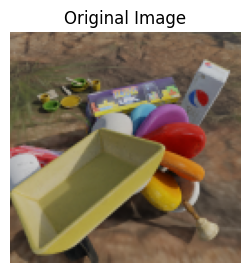

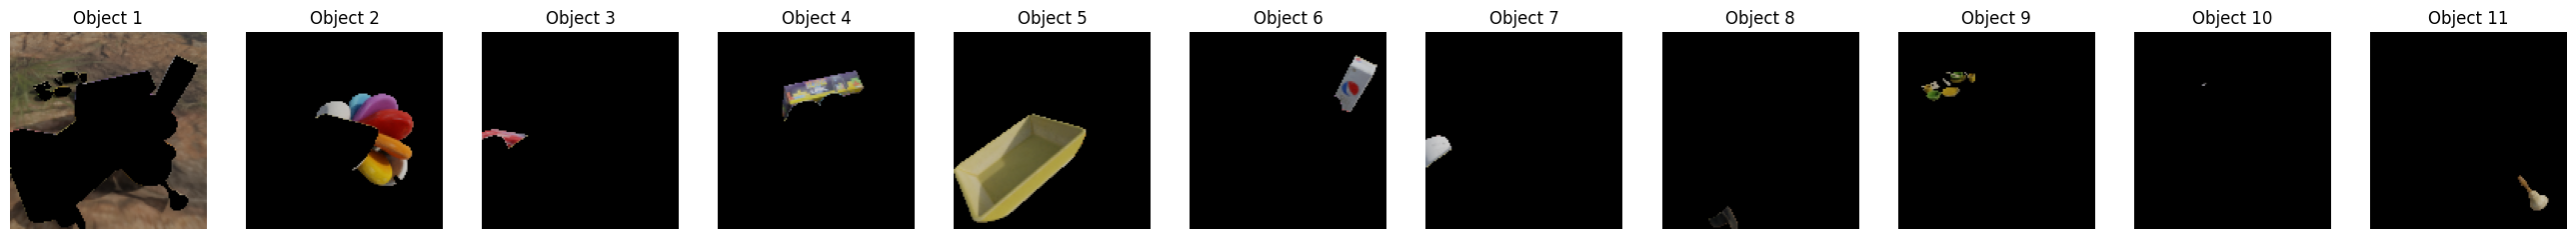

In [116]:
# Choose the first batch and first time step
batch_idx = 31
time_idx = 11

# object_frames shape: [B, T, num_objects, C, H, W]
# We'll print all object frames for this batch and time step
num_objects = len(object_frames[batch_idx][time_idx])

import matplotlib.pyplot as plt
# Plot the original image for reference
plt.figure(figsize=(3, 3))
plt.imshow(rgbs[batch_idx, time_idx].permute(1, 2, 0).cpu().numpy())
plt.title("Original Image")
plt.axis("off")
plt.show()

plt.figure(figsize=(3 * num_objects, 3))
for obj_id in range(num_objects):
    obj_img = object_frames[batch_idx, time_idx, obj_id]  # shape: [C, H, W]
    plt.subplot(1, num_objects, obj_id + 1)
    # If the object frame is all zeros, skip displaying
    if obj_img.abs().sum() == 0:
        plt.title(f"Object {obj_id}\n(empty)")
        plt.axis("off")
        continue
    plt.imshow(obj_img.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Object {obj_id+1}")
    plt.axis("off")
plt.show()


In [105]:
def extract_object_specific_frames_from_bboxes(images, bboxes):
    """
    images: Tensor of shape [B, T, C, H, W]
    bboxes: Tensor of shape [B, T, num_objects, 4] (x1, y1, x2, y2) in pixel coordinates

    Returns:
        object_frames: Tensor of shape [B, T, num_objects, C, H, W]
    """
    B, T, C, H, W = images.shape
    device = images.device
    num_objects = bboxes.shape[2]

    # Prepare output tensor
    object_frames = torch.zeros(B, T, num_objects, C, H, W, device=device, dtype=images.dtype)

    for obj_id in range(num_objects):
        for b in range(B):
            for t in range(T):
                x1, y1, x2, y2 = bboxes[b, t, obj_id]
                # Clamp coordinates to image bounds and convert to int
                x1 = int(torch.clamp(x1, 0, W-1).item())
                y1 = int(torch.clamp(y1, 0, H-1).item())
                x2 = int(torch.clamp(x2, 0, W-1).item())
                y2 = int(torch.clamp(y2, 0, H-1).item())
                # Ensure valid bbox
                if x2 > x1 and y2 > y1:
                    # Copy the region from the image to the corresponding location in object_frames
                    object_frames[b, t, obj_id, :, y1:y2, x1:x2] = images[b, t, :, y1:y2, x1:x2]
                # else: leave as zeros (background)
    return object_frames

object_frames = extract_object_specific_frames_from_bboxes(rgbs, coords['bbox'])


In [106]:
object_frames.shape

torch.Size([32, 24, 11, 3, 128, 128])

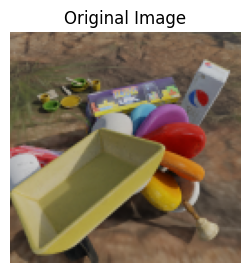

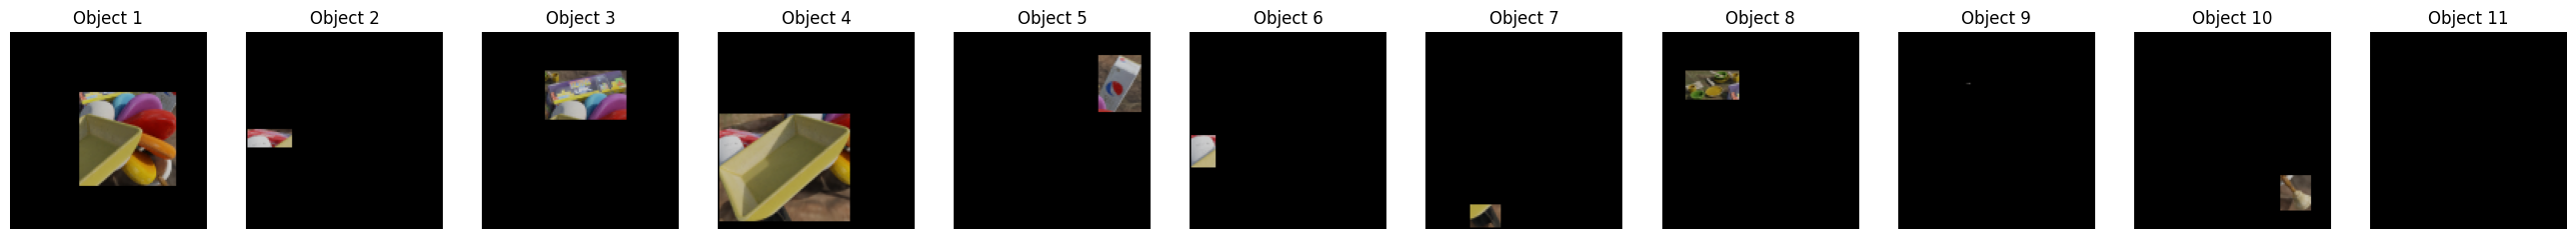

In [111]:
# Plot the original image and the extracted object frames from extract_object_specific_frames_from_bboxes

BATCH_IDX = 31
SEQ_IDX = 11

# Plot the original image
plt.figure(figsize=(3, 3))
plt.imshow(rgbs[BATCH_IDX, SEQ_IDX].permute(1, 2, 0).cpu().numpy())
plt.title("Original Image")
plt.axis("off")
plt.show()

# Plot all object frames for this sample and time step (from bboxes)
num_objects = object_frames.shape[2]
fig, axes = plt.subplots(1, num_objects, figsize=(3 * num_objects, 3))
for obj_id in range(num_objects):
    ax = axes[obj_id] if num_objects > 1 else axes
    obj_img = object_frames[BATCH_IDX, SEQ_IDX, obj_id]
    ax.imshow(obj_img.permute(1, 2, 0).cpu().numpy())
    ax.set_title(f"Object {obj_id+1}")
    ax.axis("off")
plt.show()



### Patchifier

Patchified Shape: torch.Size([32, 24, 64, 768])
Number of patches: 64
Patch size: 16


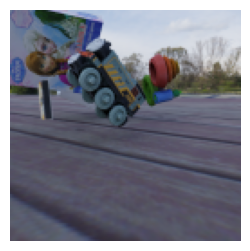

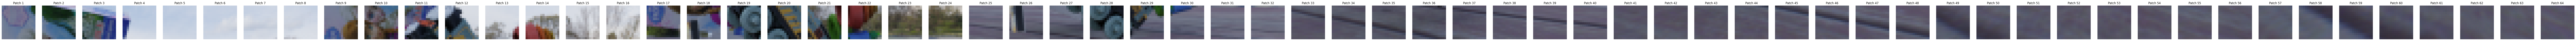

In [14]:
from model.model_utils import Patchifier

BATCH_IDX = 4
seq_len = 5
img = rgbs[BATCH_IDX, seq_len]

plt.figure(figsize=(3, 3))
plt.imshow(img.permute(1, 2, 0).cpu().numpy())
plt.axis("off")

patch_size = config['data']['patch_size'] # num of H and W pixels of each patch
patchifier = Patchifier(patch_size)
patch_data = patchifier(rgbs)
print(f"Patchified Shape: {patch_data.shape}") # (B, seq_len, num_patch_H * num_patch_W, 3 * 32 * 32)

num_patches = patch_data.shape[2] # num_patches = num_patch_H * num_patch_W
print(f"Number of patches: {num_patches}")
print(f"Patch size: {patch_size}")
fig, ax = plt.subplots(1, num_patches)
fig.set_size_inches(3 * num_patches, 3)
for i in range(num_patches):
    cur_patch = patch_data[BATCH_IDX, seq_len, i].reshape(3, patch_size, patch_size)
    ax[i].imshow(cur_patch.permute(1, 2, 0).cpu().numpy())
    ax[i].set_title(f"Patch {i+1}")
    ax[i].axis("off")

plt.show()

### Masked Autoencoders

For the first phase of the project, we would be solving the image reconstruction task. For this purpose, we train a transformer based encoder-decoder. For the sake of image reconstruction, we would need to use the masked autoencoder archirecture as in the following image:

# <img src="../docs/146857310-f258c86c-fde6-48e8-9cee-badd2b21bd2c.png" width="640" height="480">



In [38]:
from model.holistic_encoder import HolisticEncoder

encoder = HolisticEncoder(mode='training', mask_ratio=0.75)


Pe spatial shape: torch.Size([1, 24, 1, 256])


In [28]:
encoder

HolisticEncoder(
  (patch_projection): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=512, bias=True)
  )
  (encoder_pos_embed): PositionalEncoding()
  (encoder_blocks): Sequential(
    (0): TransformerBlock(
      (ln_att): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (attn): MultiHeadSelfAttention(
        (q): Linear(in_features=512, out_features=128, bias=False)
        (k): Linear(in_features=512, out_features=128, bias=False)
        (v): Linear(in_features=512, out_features=128, bias=False)
        (out_proj): Linear(in_features=128, out_features=512, bias=False)
      )
      (ln_mlp): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (mlp): Sequential(
          (0): Linear(in_features=512, out_features=1024, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=1024, out_features=512, bias=True)
        )
      )
    )
    (1): 

In [40]:
x, mask, ids_restore = encoder(rgbs)
print("x shape:", x.shape)
print("mask shape:", mask['image'].shape)
print("ids_restore shape:", ids_restore['image'].shape)

Now in training epoch, from encoder
x shape: torch.Size([32, 24, 16, 512])
mask shape: torch.Size([32, 24, 64])
ids_restore shape: torch.Size([32, 24, 64])


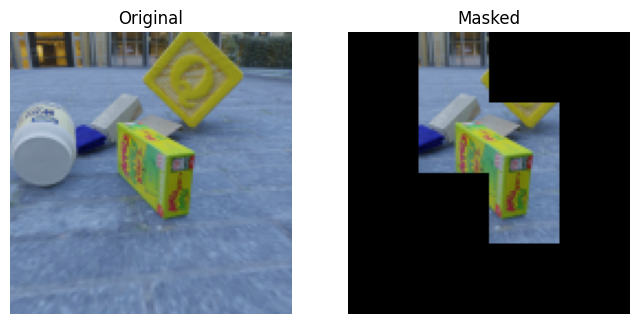

In [ ]:
from utils.visualization import visualize_masked_image

sample_idx, frame_idx = 2, 9

img = rgbs[sample_idx, frame_idx]     # [3, 128, 128]
mask_frame = mask['image'][sample_idx, frame_idx]  # [N]

visualize_masked_image(img, mask_frame, patch_size=patch_size)


## Encoder


In [ ]:
from model.encoder import MultiModalVitEncoder

encoder = MultiModalVitEncoder()
                                # patch_size = patch_size, 
                                # embed_dim = 128, 
                                # attn_dim = 192, 
                                # num_heads = 4, 
                                # mlp_size = 1024, 
                                # encoder_depth = 4, 
                                # in_chans = 3, 
                                # max_len  = 64,
                                # mask_ratio = 0.75,
                                # max_objects=11,
                                # use_masks=True,
                                # use_bboxes=False,
                                # norm_pix_loss=False)
                                
                                
encoder

MultiModalVitEncoder(
  (encoder_pos_embed): PositionalEncoding()
  (patch_projection): Sequential(
    (0): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=3072, out_features=128, bias=True)
  )
  (encoder_blocks): Sequential(
    (0): TransformerBlock(
      (ln_att): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (attn): MultiHeadSelfAttention(
        (q): Linear(in_features=128, out_features=192, bias=False)
        (k): Linear(in_features=128, out_features=192, bias=False)
        (v): Linear(in_features=128, out_features=192, bias=False)
        (out_proj): Linear(in_features=192, out_features=128, bias=False)
      )
      (ln_mlp): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (mlp): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
      )
    )
    

In [ ]:
encoded_features, mask, ids_restore = encoder(rgbs, masks , coords['bbox'])
print("Features shape:\n", encoded_features.shape)
print(f'mask and restored_ids are now dict:', mask.keys())
print("Mask shape:\n images:", mask['image'].shape,f'mask_mask:', mask['mask'].shape, f'mask_bboxs:', mask['bbox'].shape)
print("ids_restore shape:\n images:", ids_restore['image'].shape,f'mask:', ids_restore['mask'].shape, f'bboxs:', ids_restore['bbox'].shape)

Features shape:
 torch.Size([64, 24, 12, 128])
mask and restored_ids are now dict: dict_keys(['image', 'mask', 'bbox'])
Mask shape:
 images: torch.Size([64, 24, 16]) mask_mask: torch.Size([64, 24, 16]) mask_bboxs: torch.Size([64, 24, 11])
ids_restore shape:
 images: torch.Size([64, 24, 16]) mask: torch.Size([64, 24, 16]) bboxs: torch.Size([64, 24, 11])


## Decoder

In [ ]:
from model.holistic_decoder import VitDecoder

decoder = VitDecoder()
                        # patch_size = patch_size, 
                        # embed_dim = 128,
                        # decoder_embed_dim = 64,
                        # attn_dim=192, 
                        # num_heads =4, 
                        # mlp_size = 512, 
                        # decoder_depth = 2, 
                        # out_chans = 3, 
                        # max_len = 64,
                        # norm_pix_loss=False
                    # )

decoder


VitDecoder(
  (encoder_pos_embed): PositionalEncoding()
  (patch_projection): Sequential(
    (0): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=3072, out_features=128, bias=True)
  )
  (encoder_blocks): Sequential(
    (0): TransformerBlock(
      (ln_att): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (attn): MultiHeadSelfAttention(
        (q): Linear(in_features=128, out_features=192, bias=False)
        (k): Linear(in_features=128, out_features=192, bias=False)
        (v): Linear(in_features=128, out_features=192, bias=False)
        (out_proj): Linear(in_features=192, out_features=128, bias=False)
      )
      (ln_mlp): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (mlp): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
      )
    )
    (1): Trans

In [ ]:
recons, loss = decoder(encoded_features,mask['image'], ids_restore['image'])


In [ ]:
recons.shape

torch.Size([64, 24, 3, 128, 128])

### Holistic scene representation

In [7]:
from model.ocvp import TransformerAutoEncoder
from model.holistic_encoder import HolisticEncoder
from model.holistic_decoder import HolisticDecoder
from utils.utils import count_model_params

In [8]:
holistic_encoder = HolisticEncoder(mode='training')

holistic_decoder = HolisticDecoder(mode='training')

model = TransformerAutoEncoder(holistic_encoder, holistic_decoder)

print(count_model_params(model))
# model

24549248


In [9]:
rgbs, masks, flows, coords = next(iter(val_loader))

In [31]:
encoded_features = holistic_encoder(rgbs, masks, coords)
print("encoded_features shape:", encoded_features.shape)


Input images shape: torch.Size([32, 24, 3, 128, 128])
Image patches shape: torch.Size([32, 24, 64, 768])
Image tokens shape after projection: torch.Size([32, 24, 64, 512])
Image tokens shape after positional encoding: torch.Size([32, 24, 64, 512])
Encoded features shape after transformer blocks: torch.Size([32, 24, 64, 512])
Encoded features shape after layer norm: torch.Size([32, 24, 64, 512])
encoded_features shape: torch.Size([32, 24, 64, 512])


In [32]:
recons, loss = holistic_decoder(encoded_features)
recons.shape

torch.Size([32, 24, 3, 128, 128])

In [12]:
recons, loss = model(rgbs, masks, coords)
recons.shape

torch.Size([32, 24, 3, 128, 128])

### Object-Centric Scene Representation

In [10]:
from model.oc_encoder import ObjectCentricEncoder
from model.oc_decoder import ObjectCentricDecoder

In [ ]:
oc_encoder = ObjectCentricEncoder(mode='training')
encoded_features = oc_encoder(rgbs, masks, coords)
count_model_params(oc_encoder)


338219520

: 

In [34]:
oc_decoder = ObjectCentricDecoder(mode='training')
oc_decoder
recons, loss = oc_decoder(encoded_features, rgbs)
count_model_params(oc_decoder)


encoded_features shape: torch.Size([32, 24, 11, 512])
After decoder_projection, x shape: torch.Size([32, 24, 11, 384])
After decoder_pos_embed, x shape: torch.Size([32, 24, 11, 384])
After decoder block , x shape: torch.Size([32, 24, 11, 384])
After decoder_norm, x shape: torch.Size([32, 24, 11, 384])
pred_frames shape: torch.Size([32, 24, 11, 49152])
pred_frames shape after view: torch.Size([32, 24, 11, 3, 128, 128])
scene_recons shape: torch.Size([32, 24, 3, 128, 128])
target shape: torch.Size([32, 24, 3, 128, 128])
loss value: 0.2010689526796341


27009152

In [ ]:
model = TransformerAutoEncoder(oc_encoder, oc_decoder)
count_model_params(model)

365228672

: 

### Predictor

In [ ]:
from model.holistic_predictor import HolisticTransformerPredictor
from model.oc_predictor import ObjectCentricTransformerPredictor
from model.predictor_wrapper import PredictorWrapper


In [ ]:

oc_predictor = ObjectCentricTransformerPredictor()
holistic_predictor = HolisticTransformerPredictor()
predictor_wrapper = PredictorWrapper(oc_predictor, holistic_predictor)